# Przygotowanie środowiska
Import wymaganych bibliotek

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

import seaborn as sns
from sklearn.metrics import ndcg_score

from keras.initializers import RandomNormal
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import (
    Concatenate,
    Dense,
    Embedding,
    Flatten,
    Input,
    Multiply,
)
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

import optuna
from optuna.storages import RDBStorage

2025-01-22 16:09:02.811741: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
/home/david/anaconda3/envs/ML39/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Import własnych funkcji

In [3]:
from utils import *

# Dane

## Przedstawienie datasetu
W projekcie został użyty zbiór danych [MovieLens - ml-latest-small](https://grouplens.org/datasets/movielens/) który jest częstym wyborem do badań nad systemami rekomendacji  

Zawiera on onformacje o:
- 6,000 użytkownikach
- 9,000 filmach
- 100,000 opiniach

## Wczytanie danych

Dane zostały wstępnie obrobione, i zapisane w folderze `datasets`  
- Informacje dotyczące wstępnej obróbki datasetu znajdują się w pliku `./datasets/parse_datasets.ipynb`
- Informacje dotyczące sposobu załadowania danych znajdują się w pliku `./utils.py`

**Wczytanie danych**
- treningowych
- testowych
- listy urzytkowników
- listy itemów

In [4]:
train_data, test_data, users_all, items_all = load_dataset(dataset_path="./datasets/ml-latest-small")

for (label, data) in [["train_data",train_data],["test_data",test_data]]:
  print(f"{label}:")
  display(data)

train_dataset = to_dataset(train_data, batch_size=2048*5)

train_data:


,interaction,item_id,user_id
0,0,5481,447
1,1,3672,88
2,0,8711,211
3,0,8603,274
4,0,3819,602
...,...,...,...
1108570,1,1598,297
1108571,0,756,452
1108572,0,3852,90
1108573,0,5523,481


test_data:


,interaction,item_id,user_id
0,0,3051,380
1,0,5238,280
2,0,2308,199
3,0,5303,542
4,0,4682,607
...,...,...,...
61605,0,2495,523
61606,0,9235,487
61607,0,255,67
61608,0,1831,435


2025-01-22 16:09:04.317458: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2025-01-22 16:09:04.318518: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2025-01-22 16:09:04.331558: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-01-22 16:09:04.331708: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1060 6GB computeCapability: 6.1
coreClock: 1.759GHz coreCount: 10 deviceMemorySize: 5.92GiB deviceMemoryBandwidth: 178.99GiB/s
2025-01-22 16:09:04.331729: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2025-01-22 16:09:04.333147: I tensorflow/stream_executor/platfor

# Utworzenie modeli

## MF

In [ ]:
def create_model_MF(p):
  user_input = Input(shape=(1,), dtype='int32', name = 'user_input')
  item_input = Input(shape=(1,), dtype='int32', name = 'item_input')

  MF_Embedding_User = Embedding(
    input_dim = p["num_users"], output_dim = p["latent_dim"], 
    name = 'user_embedding',
    embeddings_initializer="RandomNormal", embeddings_regularizer = l2(p["embeding_l2"]), 
    input_length=1
  )
  MF_Embedding_Item = Embedding(
    input_dim = p["num_items"], output_dim = p["latent_dim"], 
    name = 'item_embedding',
    embeddings_initializer="RandomNormal", embeddings_regularizer = l2(p["embeding_l2"]), 
    input_length=1
  )   
  
  user_latent = Flatten()(MF_Embedding_User(user_input))
  item_latent = Flatten()(MF_Embedding_Item(item_input))
  
  predict_vector = Multiply(name="GMF_Layer")([user_latent, item_latent])
  prediction = Dense(1, activation='sigmoid', kernel_initializer='lecun_uniform', name = 'prediction')(predict_vector)
  
  return Model(inputs=[user_input, item_input], outputs=prediction)

## NeuMF

### Teoria
Podstawę do budowania modelu stanowi praca [Neural Collaborative Filtering](https://arxiv.org/pdf/1708.05031) z 2017 roku, która przedstawia sposób przeprowadzenia faktoryzacji macierzy z udziałem sieci neuronowej (NeuMF - Neural matrix factorization).

Implementacja sieci NeuFM oparta o Keras (stworzona przez autora He Xiangnan) znajduje się [tutaj](https://github.com/hexiangnan/neural_collaborative_filtering/blob/master/NeuMF.py)

Autorzy proponują poniższy model:  
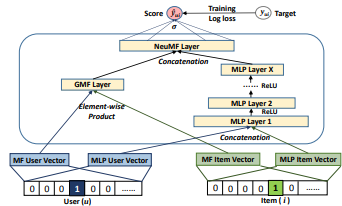




### Funkcja generująca model
#### Działanie:
`user`, `item` warstwy wejściowe  

`create_mlp(user, item)`   
    tworzy MLP_User_Vector oraz MLP_Item_Vector i przekazuje je do MLP  
	zwraca MLP  

`create_gmf(user, item)`  
	tworzy MF_User_Vector oraz MF_Item_Vector i przekazuje je do warstwy GMF_Layer która wykonuje mnorzenie macierzy  
	zwraca GMF_Layer  


następnie wyniki `create_mlp(user, item)` i `create_gmf(user, item)` są łączone i przekazywane do warstwy gęstej której wyjście jest wyjściem modelu

#### Implementacja:

In [9]:
def create_model_NeuMF(p):
  layers_mlp=[{"neurons":p["mlp_layers_neurons"]*2**x, "l2":p["mlp_l2"]} for x in range(p["mlp_layers_num"])]
  layers_mlp.reverse()
    
  def create_mlp(user, item):
    mlp_user_embedding = Embedding(
      input_dim=p["n_users"], output_dim=p["latent_dim_mlp"],
      name="MLP_User_Embedding",
      embeddings_initializer="RandomNormal", embeddings_regularizer = l2(p["embeding_l2_mlp"]),
      input_length=1,
    )
    
    mlp_item_embedding = Embedding(
      input_dim=p["n_items"], output_dim=p["latent_dim_mlp"],
      name="MLP_Item_Embedding",
      embeddings_initializer="RandomNormal", embeddings_regularizer = l2(p["embeding_l2_mlp"]),
      input_length=1,
    )
    
    mlp_user_vector = Flatten(name="MLP_User_Vector")(mlp_user_embedding(user))
    mlp_item_vector = Flatten(name="MLP_Item_Vector")(mlp_item_embedding(item))

    mlp_vector = Concatenate(name="MLP_Concatenation")([mlp_user_vector, mlp_item_vector])
    
    for i in range(len(layers_mlp)):
      layer = Dense(
        layers_mlp[i]["neurons"],
        activity_regularizer=l2(layers_mlp[i]["l2"]),
        activation="relu",
        name=f"MLP_Layer_{i+1}",
      )
      mlp_vector = layer(mlp_vector)
        
    return mlp_vector
  
  def create_gmf(user, item):
    mf_user_embedding = Embedding(
      input_dim=p["n_users"],
      output_dim=p["latent_dim_mf"],
      name="MF_User_Embedding",
      embeddings_initializer="RandomNormal",
      embeddings_regularizer=l2(p["embeding_l2_mf"]),
      input_length=1,
    )
    
    mf_item_embedding = Embedding(
      input_dim=p["n_items"],
      output_dim=p["latent_dim_mf"],
      name="MF_Item_Embedding",
      embeddings_initializer="RandomNormal",
      embeddings_regularizer=l2(p["embeding_l2_mf"]),
      input_length=1,
    )

    mf_user_vector = Flatten(name="MF_User_Vector")(mf_user_embedding(user))
    mf_item_vector = Flatten(name="MS_Item_Vector")(mf_item_embedding(item))
    
    return Multiply(name="GMF_Layer")([mf_user_vector, mf_item_vector])

  user = Input(shape=(), dtype="int32", name="user_id")
  item = Input(shape=(), dtype="int32", name="item_id")

  neumf_layer = Concatenate(name="NeuMF_Layer")([create_gmf(user, item), create_mlp(user, item)])
  output = Dense(1, activation="sigmoid", kernel_initializer="lecun_uniform", name="interaction")(neumf_layer)

  return Model(inputs=[user, item], outputs=[output])

## NeuMF advanced

Jest rozwinięciem NeuMF o MLP na końcu

In [20]:
def create_model_NeuMF_advanced(p):
  layers_mlp=[{"neurons":p["mlp_layers_neurons"]*2**x, "l2":p["mlp_l2"]} for x in range(p["mlp_layers_num"])]
  layers_mlp.reverse()
  
  layers_mlp2=[{"neurons":p["mlp2_layers_neurons"]*2**x} for x in range(p["mlp2_layers_num"])]
  layers_mlp2.reverse()
    
  def create_mlp(user, item):
    mlp_user_embedding = Embedding(
      input_dim=p["n_users"], output_dim=p["latent_dim_mlp"],
      name="MLP_User_Embedding",
      embeddings_initializer="RandomNormal", embeddings_regularizer = l2(p["embeding_l2_mlp"]),
      input_length=1,
    )
    
    mlp_item_embedding = Embedding(
      input_dim=p["n_items"], output_dim=p["latent_dim_mlp"],
      name="MLP_Item_Embedding",
      embeddings_initializer="RandomNormal", embeddings_regularizer = l2(p["embeding_l2_mlp"]),
      input_length=1,
    )
    
    mlp_user_vector = Flatten(name="MLP_User_Vector")(mlp_user_embedding(user))
    mlp_item_vector = Flatten(name="MLP_Item_Vector")(mlp_item_embedding(item))

    mlp_vector = Concatenate(name="MLP_Concatenation")([mlp_user_vector, mlp_item_vector])
    
    for i in range(len(layers_mlp)):
      layer = Dense(
        layers_mlp[i]["neurons"],
        activity_regularizer=l2(layers_mlp[i]["l2"]),
        activation="relu",
        name=f"MLP_Layer_{i+1}",
      )
      mlp_vector = layer(mlp_vector)
        
    return mlp_vector
  
  def create_gmf(user, item):
    mf_user_embedding = Embedding(
      input_dim=p["n_users"],
      output_dim=p["latent_dim_mf"],
      name="MF_User_Embedding",
      embeddings_initializer="RandomNormal",
      embeddings_regularizer=l2(p["embeding_l2_mf"]),
      input_length=1,
    )
    
    mf_item_embedding = Embedding(
      input_dim=p["n_items"],
      output_dim=p["latent_dim_mf"],
      name="MF_Item_Embedding",
      embeddings_initializer="RandomNormal",
      embeddings_regularizer=l2(p["embeding_l2_mf"]),
      input_length=1,
    )

    mf_user_vector = Flatten(name="MF_User_Vector")(mf_user_embedding(user))
    mf_item_vector = Flatten(name="MS_Item_Vector")(mf_item_embedding(item))
    
    return Multiply(name="GMF_Layer")([mf_user_vector, mf_item_vector])

  user = Input(shape=(), dtype="int32", name="user_id")
  item = Input(shape=(), dtype="int32", name="item_id")

  neumf_layer = Concatenate(name="NeuMF_Layer")([create_gmf(user, item), create_mlp(user, item)])
  
  mlp_vector = neumf_layer
  for i in range(len(layers_mlp2)):
      layer = Dense(
        layers_mlp2[i]["neurons"],
        activation="relu",
        name=f"MLP2_Layer_{i+1}",
      )
      mlp_vector = layer(mlp_vector)
  
  output = Dense(1, activation="sigmoid", kernel_initializer="lecun_uniform", name="interaction")(mlp_vector)

  return Model(inputs=[user, item], outputs=[output])

# Kompilacja i tuningowanie modeli
Tunowanie modelu przebiega z urzyciem biblioteki `optuna`. Staramy się zmaksymalizować metrykę `NDGC@10`.

Model został tuningowany pod poniższymi parametrami:
- `latent_dim_mf` - ilość wymiarów embeddingu części GMF
- `latent_dim_mlp` - ilość wymiarów embeddingu części MLP
- `embeding_l2_mf` - stopień regularyzacji `l2` urzyty dla embeddingu w GMF
- `embeding_l2_mlp` - stopień regularyzacji `l2` urzyty dla embeddingu w MLP
- `mlp_layers_num` - liczba warstw MLP
- `mlp_layers_neurons` - liczba neuronów w najmniejszej warstwie MLP
- `mlp_l2` - stopień regularyzacji `l2` urzyty dla warstw w MLP
- `mlp2_layers_num` - liczba warstw MLP2
- `mlp2_layers_neurons` - liczba neuronów w najmniejszej warstwie MLP2


Callback urzywane w trakcie szkolenia:
- `TensorBoard` - włączenie obsługi TensorBoarda
- `EarlyStoppingAtNDGC` - własny callback zatrzymujący szkolenie kiedy `NDGC@10` modelu przez `patience` epok nie rośnie

`make_metrics_vs_epochs_graphs()` - na koniec treningu wyświetla statystyki metryk względem epok

**Ustawienie liczby epok, prób oraz czy szkolenie ma być szczegółowo wyświetlane:**

In [ ]:
epochs=3
n_trials=3
verbose=1

## MF

In [ ]:
model_name = "MF"

def objective(trial):
  model = create_model_MF({
    "n_users": len(users_all),
    "n_items": len(items_all),
    
    "latent_dim_": trial.suggest_int('latent_dim_mf', 8, 128),
    "embeding_l2": trial.suggest_float('embeding_l2_mf', 0.0, 0.1)
  })
  
  model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=[
      tf.keras.metrics.BinaryAccuracy(name="accuracy"),
      tf.keras.metrics.AUC(name="auc"),
      tf.keras.metrics.Precision(name="precision"),
      tf.keras.metrics.Recall(name="recall"),
      tf.keras.metrics.TruePositives(name="tp"),
      tf.keras.metrics.FalsePositives(name="fp"),
      tf.keras.metrics.TrueNegatives(name="tn"),
      tf.keras.metrics.FalseNegatives(name="fn"),
    ],
  )
  
  logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  earlyStoppingAtNDGC = EarlyStoppingAtNDGC(patience=8, test_data=test_data)

  train_hist = model.fit(
    train_dataset,
    epochs=epochs,
    callbacks=[tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1), earlyStoppingAtNDGC],
    verbose=verbose
  ) 
  display()
  make_metrics_vs_epochs_graphs(train_hist, earlyStoppingAtNDGC)
  make_metrics_vs_k_graphs(test_data)

  return ndcg_score(earlyStoppingAtNDGC.valid_true, earlyStoppingAtNDGC.y_score, k=10)
storage = RDBStorage("sqlite:///op.db")
study = optuna.create_study(direction='maximize', storage="sqlite:///op.db")
study.optimize(objective, n_trials=n_trials, show_progress_bar=True)

## NeuMF

[I 2025-01-22 16:09:05,738] A new study created in RDB with name: no-name-d9a97f66-3637-4465-80c9-d813fce0a4e3
  0%|          | 0/20 [00:00<?, ?it/s]2025-01-22 16:09:06.125643: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2025-01-22 16:09:06.125667: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2025-01-22 16:09:06.125699: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1365] Profiler found 1 GPUs
2025-01-22 16:09:06.126378: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcupti.so.10.1
2025-01-22 16:09:06.226885: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_INSUFFICIENT_PRIVILEGES
2025-01-22 16:09:06.227052: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2025-01-22 16:09:07.302

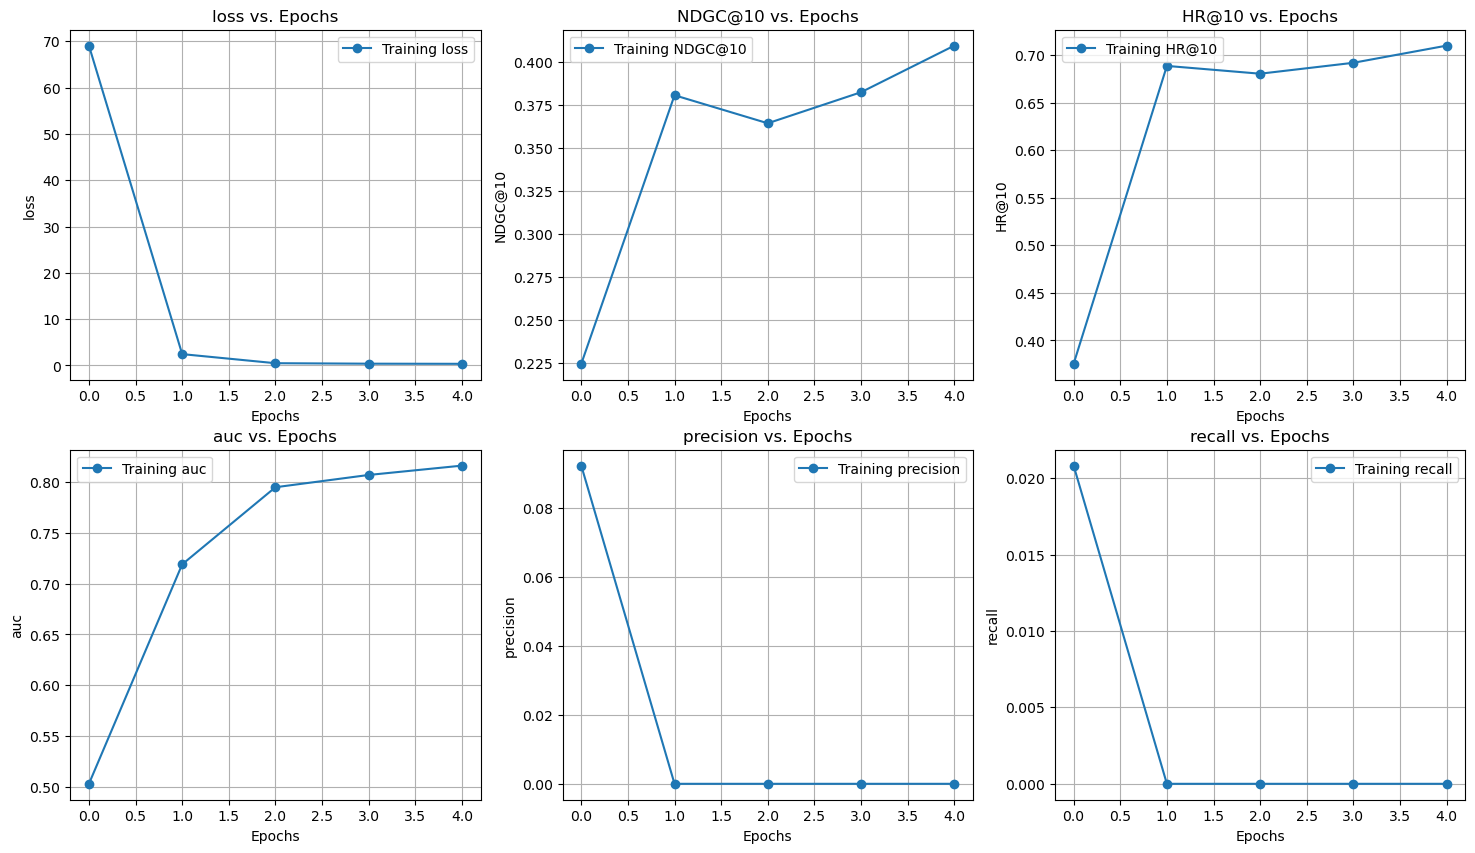

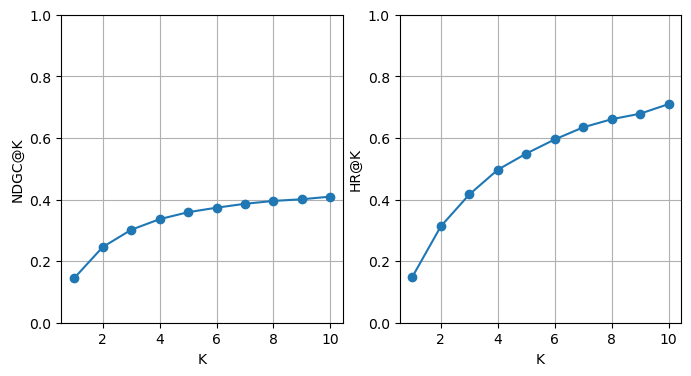

Best trial: 0. Best value: 0.409404:   5%|▌         | 1/20 [00:36<11:39, 36.81s/it]

[I 2025-01-22 16:09:42,549] Trial 0 finished with value: 0.40940410047794723 and parameters: {'latent_dim_mf': 104, 'latent_dim_mlp': 84, 'embeding_l2_mf': 0.0897581753237754, 'embeding_l2_mlp': 0.004384693095310055, 'mlp_layers_num': 2, 'mlp_layers_neurons': 18, 'mlp_l2': 0.08820558428260637}. Best is trial 0 with value: 0.40940410047794723.


2025-01-22 16:09:42.869240: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2025-01-22 16:09:42.869286: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2025-01-22 16:09:42.869330: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED
2025-01-22 16:09:42.869347: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2025-01-22 16:09:44.721082: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2025-01-22 16:09:44.721109: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2025-01-22 16:09:44.721155: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NO

2025-01-22 16:09:44.867530: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2025-01-22 16:09:44.903420: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 0 callback api events and 0 activity events. 
2025-01-22 16:09:44.920020: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2025-01-22 16:09:45.009990: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/20250122-160942/train/plugins/profile/2025_01_22_16_09_44
2025-01-22 16:09:45.061608: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to logs/20250122-160942/train/plugins/profile/2025_01_22_16_09_44/computer.trace.json.gz
2025-01-22 16:09:45.106714: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/20250122-160942/train/plugins/profile/2025_01_22_16_09_44
2025-01-22 16:09:45.110286: I tensorflow/core/pro

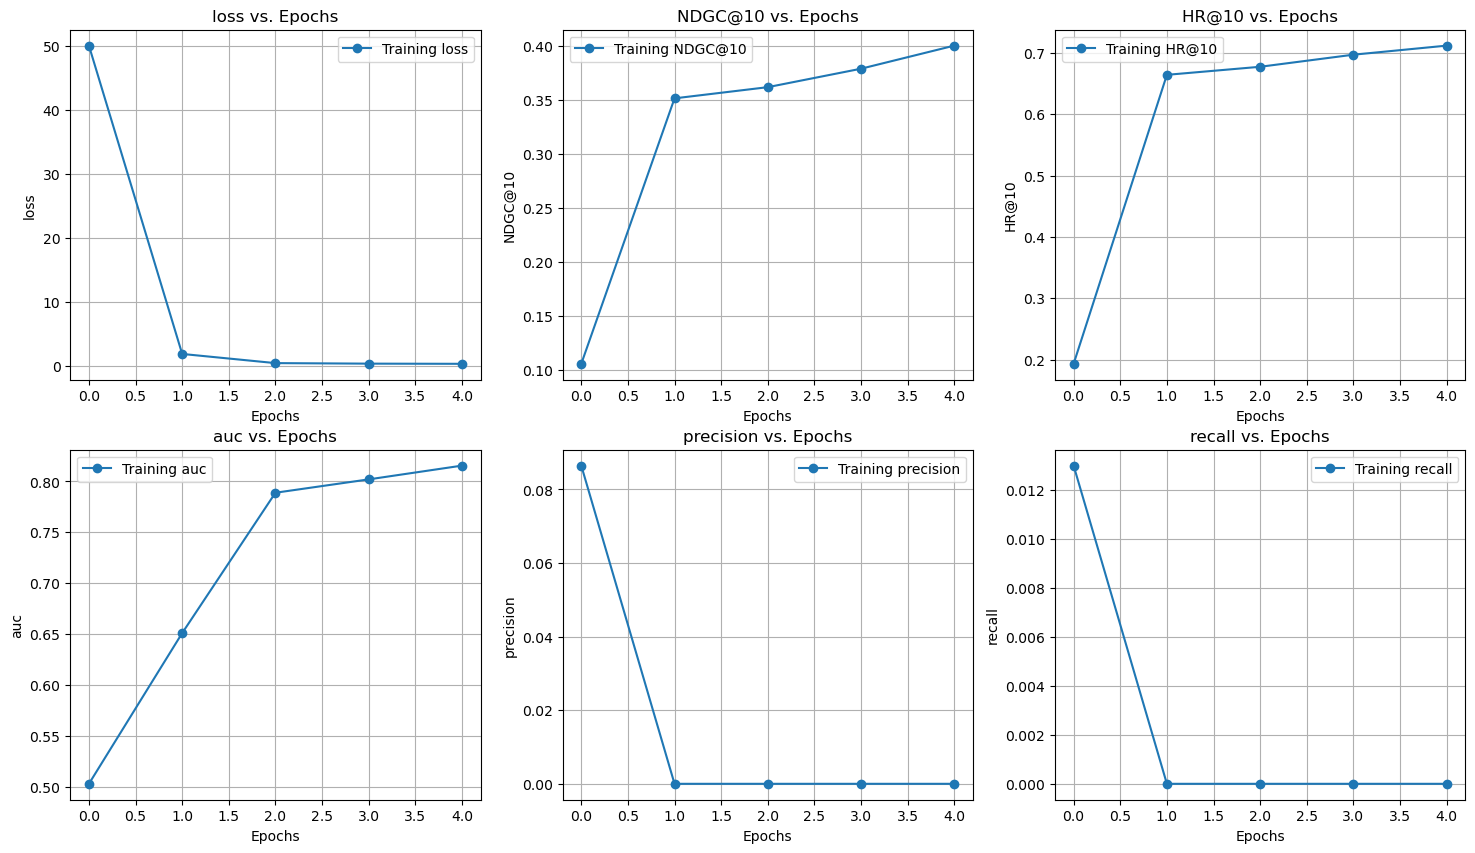

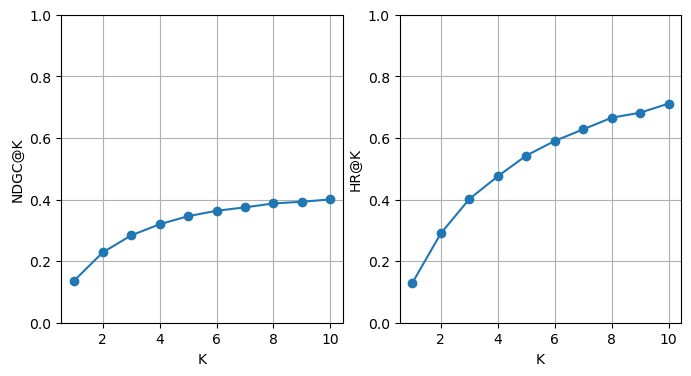

Best trial: 0. Best value: 0.409404:  10%|█         | 2/20 [01:13<11:02, 36.80s/it]

[I 2025-01-22 16:10:19,332] Trial 1 finished with value: 0.40033990759203897 and parameters: {'latent_dim_mf': 122, 'latent_dim_mlp': 52, 'embeding_l2_mf': 0.04686277420943191, 'embeding_l2_mlp': 0.024959018516110723, 'mlp_layers_num': 3, 'mlp_layers_neurons': 24, 'mlp_l2': 0.08222326816582988}. Best is trial 0 with value: 0.40940410047794723.


2025-01-22 16:10:19.639861: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2025-01-22 16:10:19.639885: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2025-01-22 16:10:19.639926: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED
2025-01-22 16:10:19.639940: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2025-01-22 16:10:21.432260: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2025-01-22 16:10:21.432288: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2025-01-22 16:10:21.432338: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NO

2025-01-22 16:10:21.571067: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2025-01-22 16:10:21.608727: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 0 callback api events and 0 activity events. 
2025-01-22 16:10:21.625949: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2025-01-22 16:10:21.717001: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/20250122-161019/train/plugins/profile/2025_01_22_16_10_21
2025-01-22 16:10:21.770107: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to logs/20250122-161019/train/plugins/profile/2025_01_22_16_10_21/computer.trace.json.gz
2025-01-22 16:10:21.816794: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/20250122-161019/train/plugins/profile/2025_01_22_16_10_21
2025-01-22 16:10:21.820694: I tensorflow/core/pro

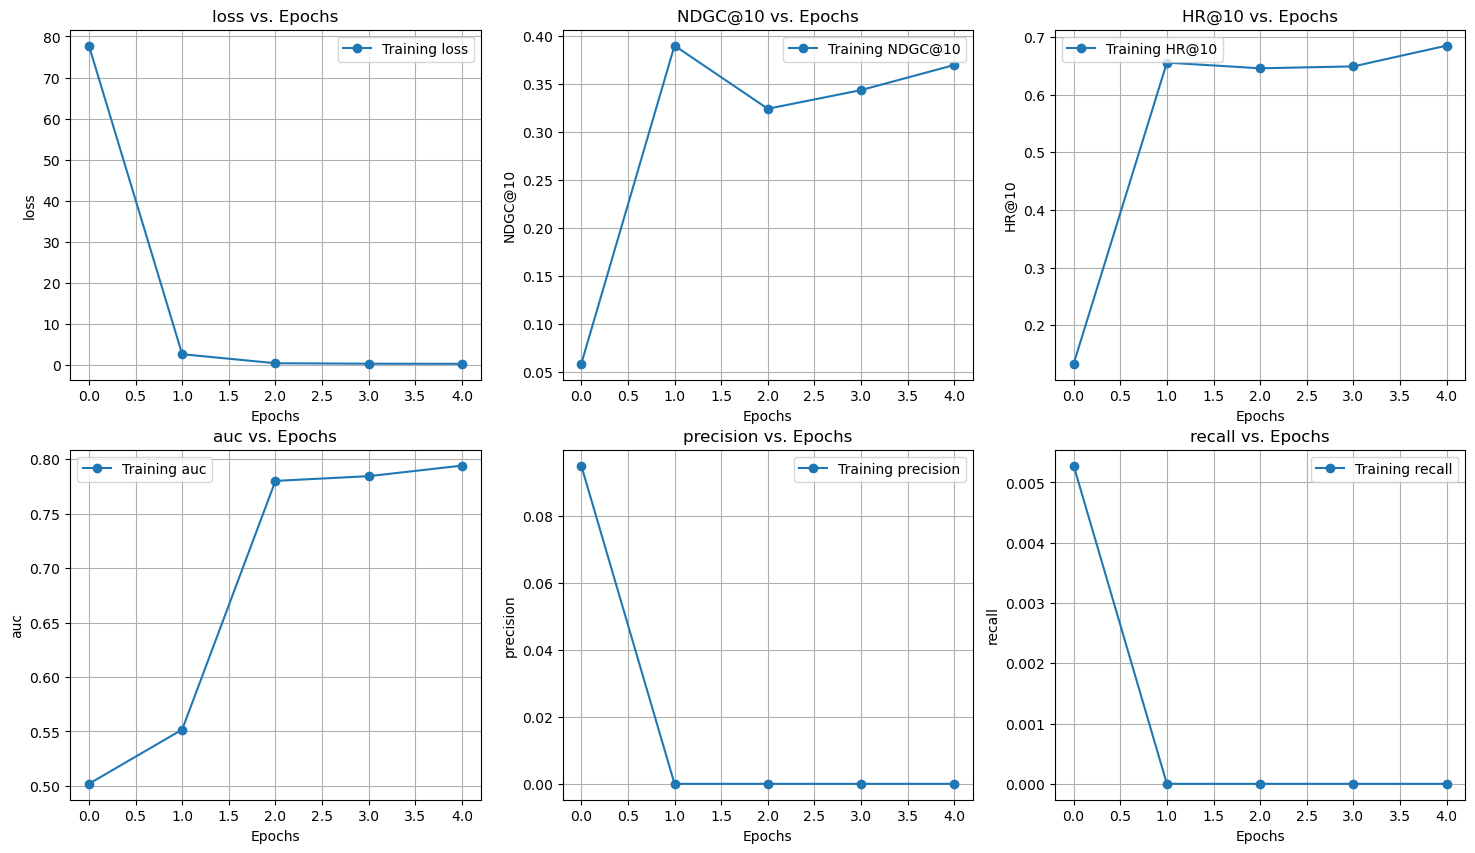

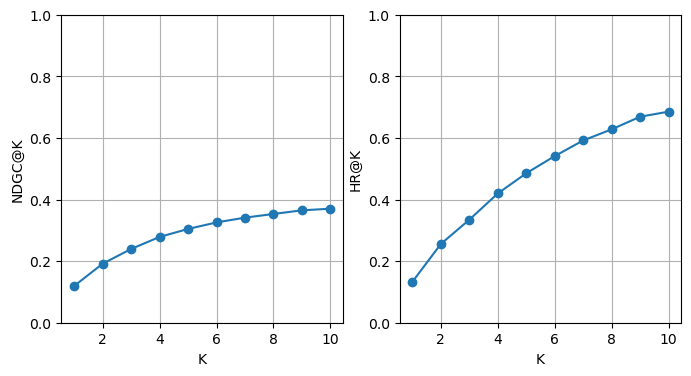

Best trial: 0. Best value: 0.409404:  15%|█▌        | 3/20 [01:50<10:27, 36.90s/it]

[I 2025-01-22 16:10:56,359] Trial 2 finished with value: 0.37016731144520715 and parameters: {'latent_dim_mf': 82, 'latent_dim_mlp': 79, 'embeding_l2_mf': 0.0734492966448879, 'embeding_l2_mlp': 0.06217233764641858, 'mlp_layers_num': 4, 'mlp_layers_neurons': 10, 'mlp_l2': 0.04718182884683662}. Best is trial 0 with value: 0.40940410047794723.


2025-01-22 16:10:56.682717: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2025-01-22 16:10:56.682745: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2025-01-22 16:10:56.682794: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED
2025-01-22 16:10:56.682809: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2025-01-22 16:10:58.505883: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2025-01-22 16:10:58.505915: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2025-01-22 16:10:58.505998: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NO

Best trial: 0. Best value: 0.409404:  15%|█▌        | 3/20 [02:01<11:27, 40.46s/it]


[W 2025-01-22 16:11:07,106] Trial 3 failed with parameters: {'latent_dim_mf': 74, 'latent_dim_mlp': 79, 'embeding_l2_mf': 0.06882578107834962, 'embeding_l2_mlp': 0.003652705379690424, 'mlp_layers_num': 6, 'mlp_layers_neurons': 7, 'mlp_l2': 0.022246319004146555} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/david/anaconda3/envs/ML39/lib/python3.9/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_47813/1074603233.py", line 34, in objective
    train_hist = model.fit(
  File "/home/david/anaconda3/envs/ML39/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py", line 1145, in fit
    callbacks.on_epoch_end(epoch, epoch_logs)
  File "/home/david/anaconda3/envs/ML39/lib/python3.9/site-packages/tensorflow/python/keras/callbacks.py", line 432, in on_epoch_end
    callback.on_epoch_end(epoch, numpy_logs)
  File "/home/david/Workspace/c_project/ML/uti

KeyboardInterrupt: 

In [ ]:
model_name = "NeuMF"

def objective(trial):
  model = create_model_NeuMF({
    "n_users": len(users_all),
    "n_items": len(items_all),
    
    "latent_dim_mf": trial.suggest_int('latent_dim_mf', 8, 128),
    "latent_dim_mlp": trial.suggest_int('latent_dim_mlp', 8, 128),
    "embeding_l2_mf": trial.suggest_float('embeding_l2_mf', 0.0, 0.1),
    "embeding_l2_mlp": trial.suggest_float('embeding_l2_mlp', 0.0, 0.1),
    
    "mlp_layers_num": trial.suggest_int('mlp_layers_num', 2, 8),
    "mlp_layers_neurons": trial.suggest_int('mlp_layers_neurons', 4, 32),
    "mlp_l2": trial.suggest_float('mlp_l2', 0.0, 0.1)
  })
  
  model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=[
      tf.keras.metrics.BinaryAccuracy(name="accuracy"),
      tf.keras.metrics.AUC(name="auc"),
      tf.keras.metrics.Precision(name="precision"),
      tf.keras.metrics.Recall(name="recall"),
      tf.keras.metrics.TruePositives(name="tp"),
      tf.keras.metrics.FalsePositives(name="fp"),
      tf.keras.metrics.TrueNegatives(name="tn"),
      tf.keras.metrics.FalseNegatives(name="fn"),
    ],
  )
  
  logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  earlyStoppingAtNDGC = EarlyStoppingAtNDGC(patience=12, test_data=test_data)

  train_hist = model.fit(
    train_dataset,
    epochs=epochs,
    callbacks=[tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1), earlyStoppingAtNDGC],
    verbose=verbose
  ) 
  display()
  make_metrics_vs_epochs_graphs(train_hist, earlyStoppingAtNDGC)
  make_metrics_vs_k_graphs(test_data)

  return ndcg_score(earlyStoppingAtNDGC.valid_true, earlyStoppingAtNDGC.y_score, k=10)
storage = RDBStorage("sqlite:///op.db")
study = optuna.create_study(direction='maximize', storage="sqlite:///op.db")
study.optimize(objective, n_trials=n_trials, show_progress_bar=True)

## NeuMF_advanced

[I 2025-01-22 16:36:36,797] A new study created in RDB with name: no-name-eca9128f-ef03-4dff-9d21-935c09a2a054
  0%|          | 0/1 [00:00<?, ?it/s]2025-01-22 16:36:37.146106: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2025-01-22 16:36:37.146141: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2025-01-22 16:36:37.146190: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED
2025-01-22 16:36:37.146206: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.


Epoch 1/10
  2/109 [..............................] - ETA: 8s - loss: 241.0312 - accuracy: 0.9090 - auc: 0.4957 - precision: 0.0000e+00 - recall: 0.0000e+00 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 13955.5000 - fn: 1404.5000

2025-01-22 16:36:38.939006: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2025-01-22 16:36:38.939031: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2025-01-22 16:36:38.939073: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED


  7/109 [>.............................] - ETA: 9s - loss: 231.8027 - accuracy: 0.9093 - auc: 0.4999 - precision: 0.0000e+00 - recall: 0.0000e+00 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 37250.4286 - fn: 3709.5714 

2025-01-22 16:36:39.078140: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2025-01-22 16:36:39.110530: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 0 callback api events and 0 activity events. 
2025-01-22 16:36:39.124830: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2025-01-22 16:36:39.197117: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/20250122-163637/train/plugins/profile/2025_01_22_16_36_39
2025-01-22 16:36:39.240554: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to logs/20250122-163637/train/plugins/profile/2025_01_22_16_36_39/computer.trace.json.gz
2025-01-22 16:36:39.286164: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/20250122-163637/train/plugins/profile/2025_01_22_16_36_39
2025-01-22 16:36:39.289068: I tensorflow/core/pro

109/109 [==============================] - 5s 32ms/step - loss: 126.1784 - accuracy: 0.9095 - auc: 0.4999 - precision: 0.0000e+00 - recall: 0.0000e+00 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 516653.4909 - fn: 51435.5091
Epoch 2/10
109/109 [==============================] - 3s 29ms/step - loss: 3.8008 - accuracy: 0.9095 - auc: 0.4993 - precision: 0.0000e+00 - recall: 0.0000e+00 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 516652.8182 - fn: 51436.1818
Epoch 3/10
109/109 [==============================] - 3s 28ms/step - loss: 0.4234 - accuracy: 0.9095 - auc: 0.4978 - precision: 0.0000e+00 - recall: 0.0000e+00 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 516653.5182 - fn: 51435.4818
Epoch 4/10
109/109 [==============================] - 3s 28ms/step - loss: 0.3084 - accuracy: 0.9095 - auc: 0.4990 - precision: 0.0000e+00 - recall: 0.0000e+00 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 516653.4000 - fn: 51435.6000
Epoch 5/10
109/109 [==============================] - 3s 29ms/step - loss: 0.3040 - accuracy:

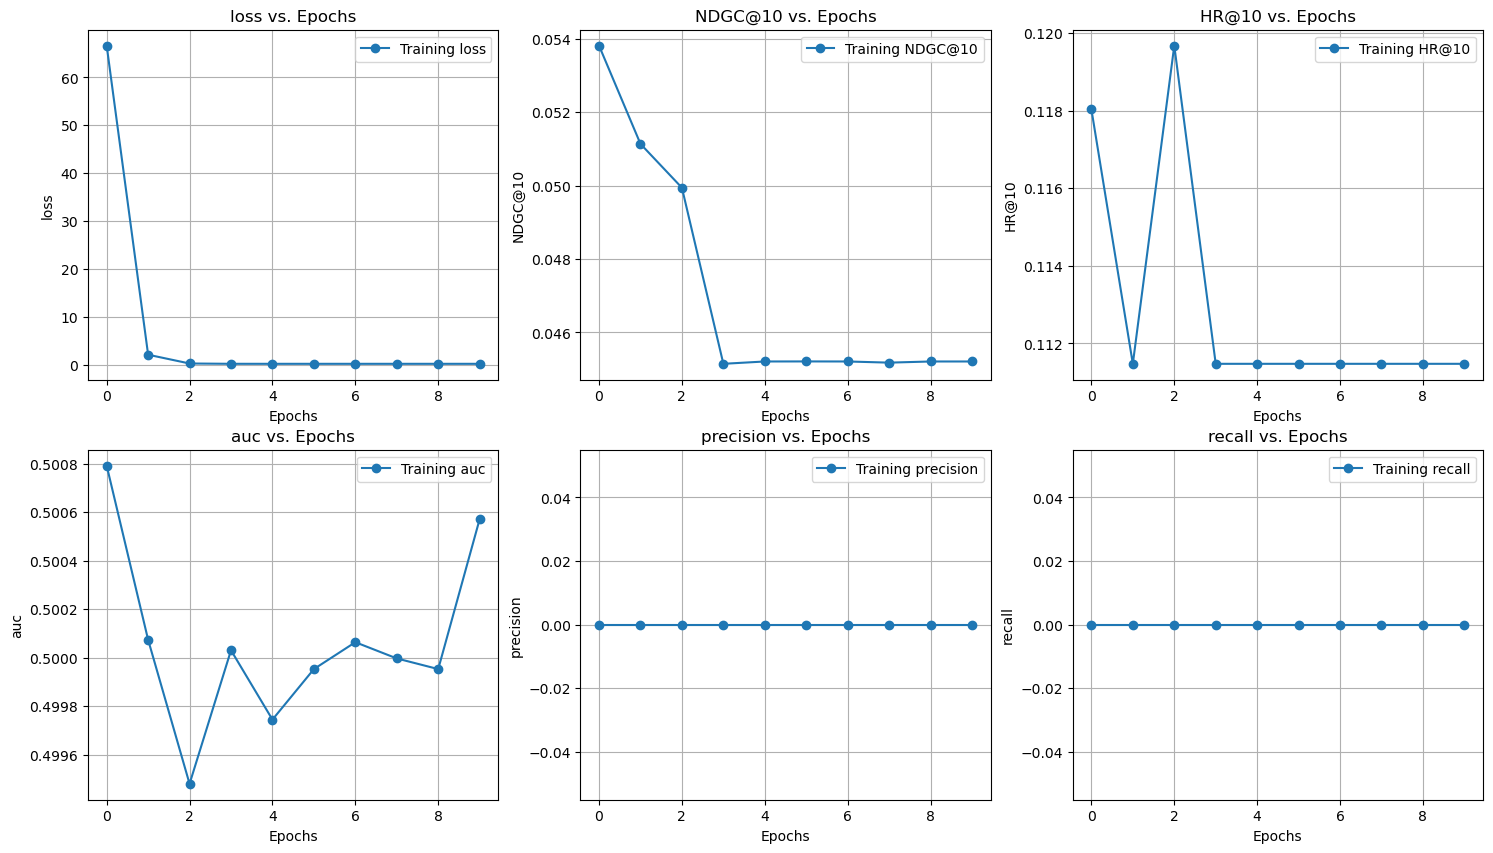

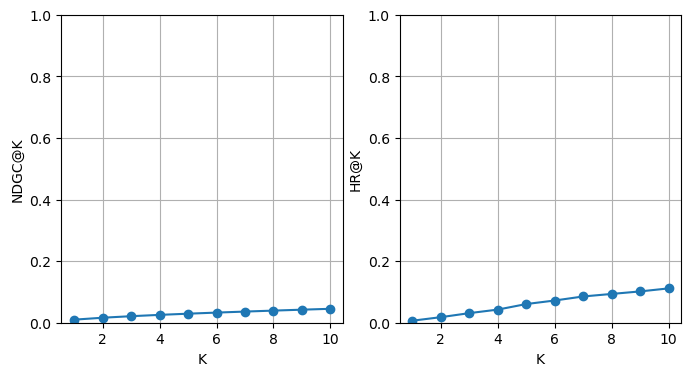

Best trial: 0. Best value: 0.0452112: 100%|██████████| 1/1 [00:57<00:00, 57.98s/it]

[I 2025-01-22 16:37:34,774] Trial 0 finished with value: 0.045211244674430655 and parameters: {'latent_dim_mf': 18, 'latent_dim_mlp': 116, 'embeding_l2_mf': 0.03023100113314985, 'embeding_l2_mlp': 0.07623969753407031, 'mlp_layers_num': 8, 'mlp_layers_neurons': 4, 'mlp_l2': 0.028303256057109608, 'mlp2_layers_num': 3, 'mlp2_layers_neurons': 25}. Best is trial 0 with value: 0.045211244674430655.


In [24]:
model_name = "NeuMF_advanced"

def objective(trial):
  model = create_model_NeuMF_advanced({
    "n_users": len(users_all),
    "n_items": len(items_all),
    
    "latent_dim_mf": trial.suggest_int('latent_dim_mf', 8, 128),
    "latent_dim_mlp": trial.suggest_int('latent_dim_mlp', 8, 128),
    "embeding_l2_mf": trial.suggest_float('embeding_l2_mf', 0.0, 0.1),
    "embeding_l2_mlp": trial.suggest_float('embeding_l2_mlp', 0.0, 0.1),
    
    "mlp_layers_num": trial.suggest_int('mlp_layers_num', 2, 8),
    "mlp_layers_neurons": trial.suggest_int('mlp_layers_neurons', 4, 32),
    "mlp_l2": trial.suggest_float('mlp_l2', 0.0, 0.1),
    
    "mlp2_layers_num": trial.suggest_int('mlp2_layers_num', 2, 8),
    "mlp2_layers_neurons": trial.suggest_int('mlp2_layers_neurons', 4, 32),
  })
  
  model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=[
      tf.keras.metrics.BinaryAccuracy(name="accuracy"),
      tf.keras.metrics.AUC(name="auc"),
      tf.keras.metrics.Precision(name="precision"),
      tf.keras.metrics.Recall(name="recall"),
      tf.keras.metrics.TruePositives(name="tp"),
      tf.keras.metrics.FalsePositives(name="fp"),
      tf.keras.metrics.TrueNegatives(name="tn"),
      tf.keras.metrics.FalseNegatives(name="fn"),
    ],
  )
  
  logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  earlyStoppingAtNDGC = EarlyStoppingAtNDGC(patience=12, test_data=test_data)

  train_hist = model.fit(
    train_dataset,
    epochs=epochs,
    callbacks=[tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1), earlyStoppingAtNDGC],
    verbose=verbose
  ) 
  display()
  make_metrics_vs_epochs_graphs(train_hist, earlyStoppingAtNDGC)
  make_metrics_vs_k_graphs(test_data)

  return ndcg_score(earlyStoppingAtNDGC.valid_true, earlyStoppingAtNDGC.y_score, k=10)
storage = RDBStorage("sqlite:///op.db")
study = optuna.create_study(direction='maximize', storage="sqlite:///op.db")
study.optimize(objective, n_trials=n_trials, show_progress_bar=True)

## Zapisanie najleprzej architektury do pliku

In [25]:
import json

best_params = study.best_params
best_params["n_users"] = len(users_all)
best_params["n_items"] = len(items_all)

with open(f"model_architectures/{model_name}_hiper_params.json", "w") as json_file:
    json_file.write(json.dumps(best_params))

: 

## Struktura najlepszej architektury

Model: "model_35"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_id (InputLayer)            [(None,)]            0                                            
__________________________________________________________________________________________________
item_id (InputLayer)            [(None,)]            0                                            
__________________________________________________________________________________________________
MLP_User_Embedding (Embedding)  (None, 8)            4880        user_id[0][0]                    
__________________________________________________________________________________________________
MLP_Item_Embedding (Embedding)  (None, 8)            77792       item_id[0][0]                    
___________________________________________________________________________________________

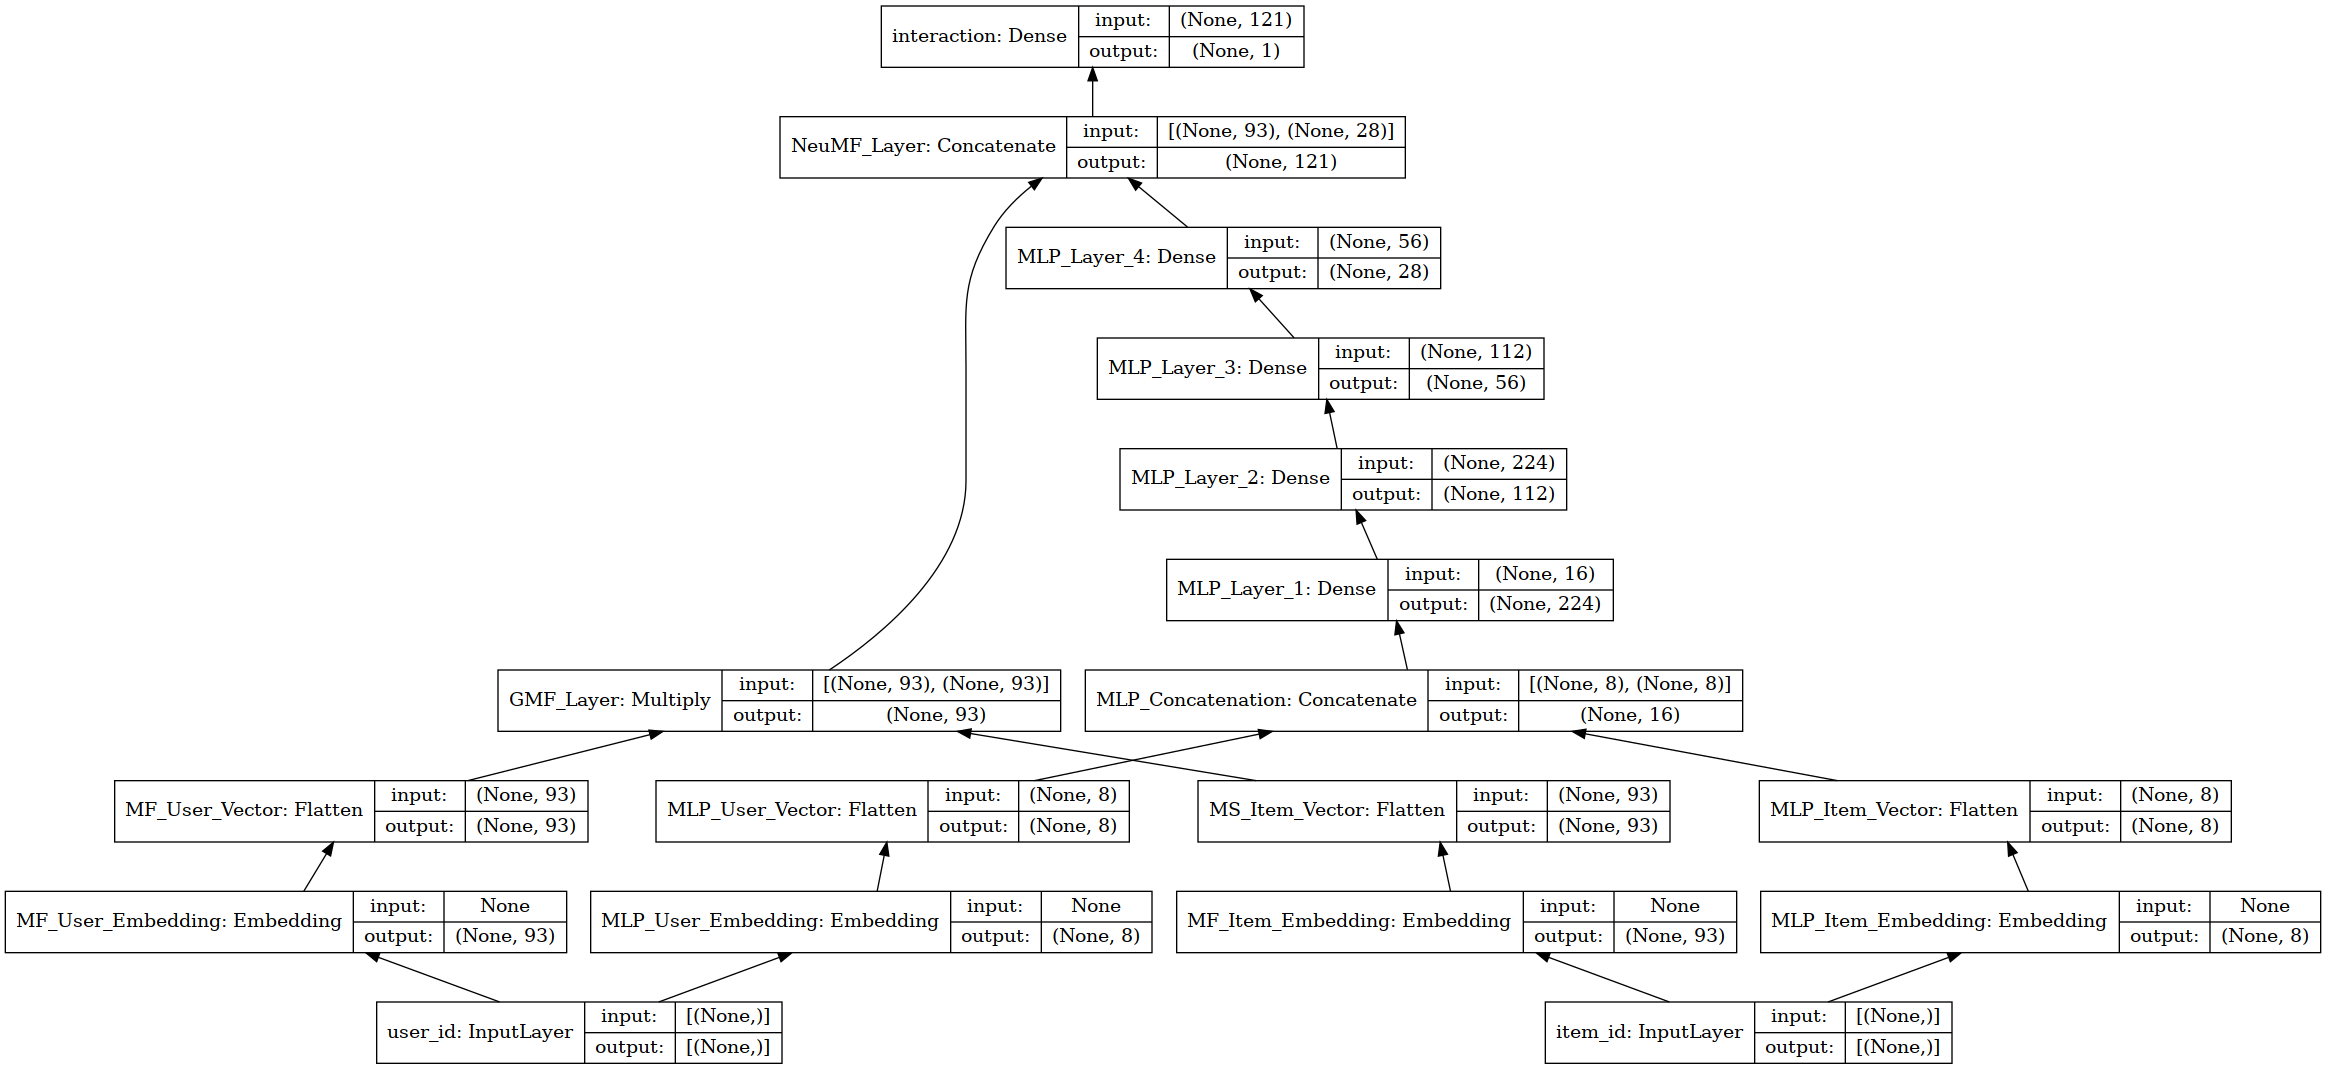

In [20]:
model = create_model_NeuMF(best_params)
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, rankdir="BT",)